In [1]:
import random


def create_grid(n_rows, n_cols, n_group1, n_group2):
    # Grid als Liste von Listen erstellen und auf jede Position eine unbewohnte Zelle setzen
    grid = []
    for i in range(n_rows):
        row = []
        for j in range(n_cols):
            cell = {
                "row": i,
                "col": j,
                "resident": 0,
                "share_of_same_group": None,
                "neighbor_cells": [],
            }
            row.append(cell)
            
        grid.append(row)
    
    # Alle Zellen auch in einer normalen, flachen Liste speichern, 
    # damit man einfacher per For-Loop alle Zellen durchgehen kann
    cell_population = []
    for row in grid:
        for cell in row:
            cell_population.append(cell)
    
    # für jede Zelle die benachbarten Zellen finden
    for cell in cell_population:
        find_neighbor_cells(cell, grid)
    
    # Agenten der Gruppe 1 auf Grid setzen
    for i in range(n_group1):
        empty_cells, occupied_cells = get_empty_and_occupied_cells(cell_population)
        random_empty_cell = random.choice(empty_cells)
        random_empty_cell["resident"] = 1

    # Agenten der Gruppe 2 auf Grid setzen
    for i in range(n_group2):
        empty_cells, occupied_cells = get_empty_and_occupied_cells(cell_population)
        random_empty_cell = random.choice(empty_cells)
        random_empty_cell["resident"] = 2
    
    return grid, cell_population



def find_neighbor_cells(cell, grid):
    # Anzahl der Zeilen des Grids ermitteln
    n_rows = len(grid)
    
    # Anzahl der Spalten bzw. Zellen in einer Zeile des Grids anhand der ersten Zeile ermitteln
    n_cols = len(grid[0])
    
    # für jede Zweilenpositionsabweichung
    for row_deviation in [-1, 0, 1]:
         
        # für jede Spaltenpositionsabweichung
        for col_deviation in [-1, 0, 1]:
            
            # wenn nicht Zeilen- und Spaltenabweichung beide 0 sind
            if not (row_deviation == 0 and col_deviation == 0):
            
                # Zeilen- und Spaltenposition der Nachbarzelle berechnen
                neighbor_row = (cell["row"] - row_deviation) % n_rows
                neighbor_col = (cell["col"] - col_deviation) % n_cols

                # Nachbarzelle im grid finden und der betrachteten Zelle in die Liste von Nachbarzellen einfügen
                neighbor_cell = grid[neighbor_row][neighbor_col]
                cell["neighbor_cells"].append(neighbor_cell)
                

def get_empty_and_occupied_cells(cell_population):
    
    # Liste für alle unbewohnten Zellen
    empty_cells = []
    
    # Liste für alle bewohnten Zellen
    occupied_cells = []
    
    # Alle Zellen durchgehen und prüfen, ob Zelle unbewohnt. Dann entsprechender Liste anhängen.
    for cell in cell_population:
        if cell["resident"] == 0:
            empty_cells.append(cell)
        else:
            occupied_cells.append(cell)
    
    return empty_cells, occupied_cells


def eval_neighborhood(cell):
    # Variable zur Zählung der aktuell bewohnten Nachbarzellen
    n_neighbors = 0
    
    # Variable zur Zählung der durch Mitglieder derselben Gruppe bewohnte Nachbarzellen
    n_neighbors_of_same_group = 0
    
    # für jede Nachbarzelle
    for neighbor_cell in cell["neighbor_cells"]:
        
        # wenn Zelle bewohnt, n_neighbors um 1 erhöhen
        if neighbor_cell["resident"] != 0:
            n_neighbors += 1
        
        # wenn Zelle mit Mitglied derselben Gruppe bewohnt, dann n_neighbors_of_same_group um 1 erhöhen
        if neighbor_cell["resident"] == cell["resident"]:
            n_neighbors_of_same_group += 1
    
    # Wenn es Nachbarn gibt
    if n_neighbors > 0:
        # Anteil derselben Gruppe unter Nachbarn berechnen und einspeichern
        cell["share_of_same_group"] = n_neighbors_of_same_group / n_neighbors
    
    # ansonten
    else:
        # "Missing" eintragen
        cell["share_of_same_group"] = 999
        

def run_model(threshold, ticks=10000, n_rows=20, n_cols=20, n_group1=180, n_group2=180):
    
    # Grid erstellen
    grid, cell_population = create_grid(n_rows, n_cols, n_group1, n_group2)
    
    ###############################################
    # Simulationsloop
    ###############################################
    
    # für jeden Zeitschritt
    for tick in range(ticks):
        
        # zwei Listen mit allen leeren und bewohnten Zellen erstellen
        empty_cells, occupied_cells = get_empty_and_occupied_cells(cell_population)
        
        # eine zufällige Zelle aussuchen
        random_cell = random.choice(occupied_cells)
        
        # ausgesuchte Zelle schaut, wie hoch der Anteil der eigenen Gruppe in Nachbarschaft ist
        eval_neighborhood(random_cell)
        
        # Wenn in Nachbarschaft zu wenige aus derselben Gruppe wie Agent sind
        if random_cell["share_of_same_group"] < threshold:
            
            # zufällige neue, unbewohnte Zelle aussuchen
            new_cell = random.choice(empty_cells)
            
            # der neuen Zelle den Agenten zuweisen
            new_cell["resident"] = random_cell["resident"]
            
            # den Agenten bei alter Zelle "löschen"
            random_cell["resident"] = 0
    
    
    segregation_data = []
    for cell in cell_population:
        eval_neighborhood(cell)
        if cell["share_of_same_group"] <= 1:
            segregation_data.append(cell["share_of_same_group"])
    
    segregation = sum(segregation_data) / len(segregation_data)
    
    output_dict = {
        "segregation": segregation,
        "threshold": threshold,
        "ticks": ticks,
        "n_rows": n_rows,
        "n_cols": n_cols,
        "n_rows": n_rows,
    }
    
    return output_dict

In [2]:
data = []
list_of_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for threshold in list_of_thresholds:
    for replication in range(10):
        data.append(run_model(threshold=threshold))

In [3]:
import pandas as pd


df = pd.DataFrame(data)

In [4]:
df

,segregation,threshold,ticks,n_rows,n_cols
0,0.480530,0.0,10000,20,20
1,0.471958,0.0,10000,20,20
2,0.461750,0.0,10000,20,20
3,0.467470,0.0,10000,20,20
4,0.455655,0.0,10000,20,20
...,...,...,...,...,...
105,0.484857,1.0,10000,20,20
106,0.488792,1.0,10000,20,20
107,0.465158,1.0,10000,20,20
108,0.439357,1.0,10000,20,20


(0.0, 1.0)

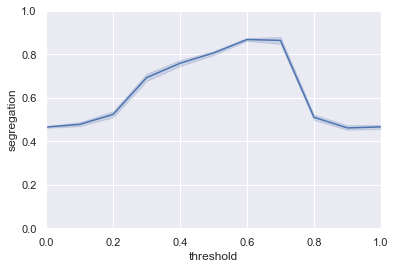

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

sns.lineplot(data=df, x="threshold", y="segregation")
plt.xlim([0, 1])
plt.ylim([0, 1])